# CZ3006 Lab 4 : Analyzing Network Data Log

In [8]:
!pip install plotly
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb
from pprint import pprint
import requests
import networkx as nx
import plotly.graph_objects as go
import matplotlib.colors as colors
import matplotlib.cm as cmx

In [9]:
from IPython.display import HTML, display

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [10]:
# from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [11]:
# Field : Description
field_dict = {'type' : "FLOW", 
               'sflow_agent_address' : "IP address of the agent", 
               'inputPort' : "Router/switch port number receiving the packet", 
               'outputPort' : "Router/switch port number through which the packet is send out", 
               'src_MAC' : "MAC address of the transmitting host", 
               'dst_MAC' : "MAC address of the receiving host", 
               'ethernet_type' : "802.3/Ethernet",
               'in_vlan' : "VLAN on which the packet is received", 
               'out_vlan' : "VLAN on which the packet is send out", 
               'src_IP' : "IP address of the sundering host of the packet", 
               'dst_IP' : "IP address of the receiver host of the packet", 
               'IP_protocol' : "IP protocol type (TCP=6 & UDP=17)", 
               'ip_tos' : "Type of service", 
               'ip_ttl' : "Value of the Time to Live attribute of the packet",
               'udp_src_port/tcp_src_port/icmp_type' : "Source port address at the transport level", 
               'udp_dst_port/tcp_dst_port/icmp_code' : "Destination port address which define the application service requested (https://www.webopedia.com/quick_ref/portnumbers.asp)", 
               'tcp_flags' : "TCP flags attribute specifying type of packet (SYN, etc)",
               'packet_size' : "Packet size including MAC headers", 
               'IP_size' : "IP packet size", 
               'sampling_rate' : "Sampling rate of the packets collected"}

In [12]:
# DATA = "../input/test_SFLow_data.csv.csv"
DATA = "SFlow_Data_lab4.csv.csv"

## Fields in SFLOW_Data

In [13]:
pprint(list(field_dict.keys()))

['type',
 'sflow_agent_address',
 'inputPort',
 'outputPort',
 'src_MAC',
 'dst_MAC',
 'ethernet_type',
 'in_vlan',
 'out_vlan',
 'src_IP',
 'dst_IP',
 'IP_protocol',
 'ip_tos',
 'ip_ttl',
 'udp_src_port/tcp_src_port/icmp_type',
 'udp_dst_port/tcp_dst_port/icmp_code',
 'tcp_flags',
 'packet_size',
 'IP_size',
 'sampling_rate']


## Display SFLOW_Data

In [14]:
SFLOW_Data = pd.read_csv(DATA, header=None)
SFLOW_Data = SFLOW_Data.drop(columns = [20])
SFLOW_Data.columns = field_dict.keys()
SFLOW_Data

type sflow_agent_address  inputPort  outputPort       src_MAC  \
0      FLOW         aa.aa.aa.aa        137         200  d404ff55fd4d   
1      FLOW         aa.aa.aa.aa        129         193  609c9f851b00   
2      FLOW         aa.aa.aa.aa        137         200  d404ff55fd4d   
3      FLOW         aa.aa.aa.aa        129         135  609c9f851b00   
4      FLOW         aa.aa.aa.aa        130         199  00239cd087c1   
...     ...                 ...        ...         ...           ...   
69365  FLOW         aa.aa.aa.aa        258         199  204e71cf1b0f   
69366  FLOW         aa.aa.aa.aa        131         193  00a742233e9e   
69367  FLOW         aa.aa.aa.aa        130         199  00239cd087c1   
69368  FLOW         aa.aa.aa.aa        129         193  609c9f851b00   
69369  FLOW         aa.aa.aa.aa        137         200  d404ff55fd4d   

            dst_MAC ethernet_type  in_vlan  out_vlan           src_IP  \
0      80711fc76001        0x0800    919.0       280   130.246.176.22   
1      0031466b23cf        0x0800     11.0       919    155.69.160.32   
2      80711fc76001        0x0800    919.0       280   130.246.176.53   
3      002688cd5fc7        0x0800     11.0       919    155.69.160.32   
4      544b8cf9a7df        0x0800    919.0       600   137.132.228.15   
...             ...           ...      ...       ...              ...   
69365  ccef48570144        0x0800    537.0       601  207.241.228.157   
69366  0031466b23cf        0x0800     43.0       919   192.122.131.36   
69367  544b8cf9a7df        0x0800    919.0       600   137.132.228.15   
69368  0031466b23cf        0x0800     11.0       919     155.69.196.9   
69369  80711fc76001        0x0800    919.0       280    14.139.196.58   

                dst_IP  IP_protocol ip_tos  ip_ttl  \
0        140.115.32.81            6   0x00      50   
1       64.233.188.128            6   0x00      56   
2        140.115.32.83            6   0x00      50   
3        54.169.174.79           17   0x00     120   
4         193.62.192.8            6   0x00      56   
...                ...          ...    ...     ...   
69365     210.48.222.9            6   0x00      56   
69366   216.58.203.234            6   0x00     121   
69367     193.62.192.8            6   0x00      56   
69368      74.125.56.6           17   0x00      58   
69369  192.101.107.153            6   0x00      57   

       udp_src_port/tcp_src_port/icmp_type  \
0                                  51216.0   
1                                  23159.0   
2                                  50041.0   
3                                  54241.0   
4                                  53923.0   
...                                    ...   
69365                                443.0   
69366                               4920.0   
69367                              34153.0   
69368                              56221.0   
69369                              34625.0   

       udp_dst_port/tcp_dst_port/icmp_code tcp_flags  packet_size  IP_size  \
0                                    23505      0x10         1518     1500   
1                                       80      0x10           74       52   
2                                    20739      0x10         1518     1500   
3                                    26510      0x10          116       94   
4                                    34262      0x10           70       52   
...                                    ...       ...          ...      ...   
69365                                57434      0x10         1522     1500   
69366                                  443      0x10         1442     1420   
69367                                 3123      0x10           82       64   
69368                                60786      0x10         1267     1245   
69369                                41211      0x10           58       40   

       sampling_rate  
0               2048  
1               2048  
2               2048  
3               2048  
4          

## DataType of columns

In [15]:
print(SFLOW_Data.dtypes)
print("\nSize of the dataframe:", len(SFLOW_Data))

type                                    object
sflow_agent_address                     object
inputPort                                int64
outputPort                               int64
src_MAC                                 object
dst_MAC                                 object
ethernet_type                           object
in_vlan                                float64
out_vlan                                 int64
src_IP                                  object
dst_IP                                  object
IP_protocol                              int64
ip_tos                                  object
ip_ttl                                   int64
udp_src_port/tcp_src_port/icmp_type    float64
udp_dst_port/tcp_dst_port/icmp_code      int64
tcp_flags                               object
packet_size                              int64
IP_size                                  int64
sampling_rate                            int64
dtype: object

Size of the dataframe: 69370


## Unique values of columns

In [16]:
print("The following are unique values for the data's attributes.")
for field in field_dict.keys():
    print(field, ":\t", len(SFLOW_Data[field].unique()))

The following are unique values for the data's attributes.
type :	 2
sflow_agent_address :	 1
inputPort :	 29
outputPort :	 31
src_MAC :	 62
dst_MAC :	 62
ethernet_type :	 6
in_vlan :	 480
out_vlan :	 1217
src_IP :	 3879
dst_IP :	 3183
IP_protocol :	 10
ip_tos :	 35
ip_ttl :	 100
udp_src_port/tcp_src_port/icmp_type :	 9385
udp_dst_port/tcp_dst_port/icmp_code :	 7679
tcp_flags :	 929
packet_size :	 1683
IP_size :	 1287
sampling_rate :	 2


# Exercise 4A: TOP TALKERS and LISTENERS

In [17]:
def find_org(IP):
    url = "http://free.ipwhois.io/json/" + IP
    r = requests.get(url)
    try:
        data = r.json()
        return data["org"]
    except:
        return ""

In [18]:
top_talkers = pd.DataFrame(SFLOW_Data['src_IP'].value_counts()).reset_index()
top_talkers.columns = ["src_IP", "src_IP_packet_count"]
top_talkers = top_talkers.nlargest(5, 'src_IP_packet_count')
top_talkers["Organisation"] = top_talkers["src_IP"].apply(find_org)
top_talkers

src_IP  src_IP_packet_count                      Organisation
0   193.62.192.8                 3041                             JANET
1  155.69.160.32                 2975  Nanyang Technological University
2  130.14.250.11                 2604      National Library of Medicine
3  14.139.196.58                 2452        National Knowledge Network
4  140.112.8.139                 2056        National Taiwan University

In [19]:
top_listeners = pd.DataFrame(SFLOW_Data['dst_IP'].value_counts()).reset_index()
top_listeners.columns = ["dst_IP", "dst_IP_packet_count"]
top_listeners = top_listeners.nlargest(5, 'dst_IP_packet_count')
top_listeners["Organisation"] = top_listeners["dst_IP"].apply(find_org)
top_listeners

dst_IP  dst_IP_packet_count                      Organisation
0   103.37.198.100                 3841                            A*STAR
1   137.132.228.15                 3715  National University of Singapore
2   202.21.159.244                 2446   Republic Polytechnic, Singapore
3  192.101.107.153                 2368                             ESnet
4     103.21.126.2                 2056                              IITB

# Exercise 4B: TRANSPORT PROTOCOL
Transport protocol numbers referenced from https://en.wikipedia.org/wiki/List_of_IP_protocol_numbers

In [20]:
IP_protocol_dict = {
    0   : "HOPOPT",
    1   : "ICMP",
    6   : "TCP",
    17  : "UDP",
    41  : "IPv6",
    47  : "GREs",
    50  : "ESP",
    58  : "IPv6-ICMP",
    103 : "PIM",
    381 : "381",
}

In [21]:
print(f"Total number of packets = {SFLOW_Data.shape[0]}")

Total number of packets = 69370


In [22]:
protocols_of_interest = ["TCP", "UDP", "ESP", "HOPOPT", "GREs"]
IP_protocol_list = SFLOW_Data["IP_protocol"].unique()
total_count = SFLOW_Data.shape[0]
for no in IP_protocol_list:
    if IP_protocol_dict[no] in protocols_of_interest:
        print(f"[IP protocol {no}, {IP_protocol_dict[no]}]")
        temp_protocol_DF = SFLOW_Data[SFLOW_Data["IP_protocol"]==no]
        packet_count = temp_protocol_DF.shape[0]
        percentage_of_current_protocol = packet_count/total_count * 100
        print(f"Packet count : {packet_count} packets")
        print(f"Proportion of protocol {no} (in %) : {round(percentage_of_current_protocol,2)}%")
        display(temp_protocol_DF)
        

[IP protocol 6, TCP]
Packet count : 56064 packets
Proportion of protocol 6 (in %) : 80.82%


type sflow_agent_address  inputPort  outputPort       src_MAC  \
0      FLOW         aa.aa.aa.aa        137         200  d404ff55fd4d   
1      FLOW         aa.aa.aa.aa        129         193  609c9f851b00   
2      FLOW         aa.aa.aa.aa        137         200  d404ff55fd4d   
4      FLOW         aa.aa.aa.aa        130         199  00239cd087c1   
6      FLOW         aa.aa.aa.aa        130         199  00239cd087c1   
...     ...                 ...        ...         ...           ...   
69364  FLOW         aa.aa.aa.aa        258         130  204e71cf1b0f   
69365  FLOW         aa.aa.aa.aa        258         199  204e71cf1b0f   
69366  FLOW         aa.aa.aa.aa        131         193  00a742233e9e   
69367  FLOW         aa.aa.aa.aa        130         199  00239cd087c1   
69369  FLOW         aa.aa.aa.aa        137         200  d404ff55fd4d   

            dst_MAC ethernet_type  in_vlan  out_vlan           src_IP  \
0      80711fc76001        0x0800    919.0       280   130.246.176.22   
1      0031466b23cf        0x0800     11.0       919    155.69.160.32   
2      80711fc76001        0x0800    919.0       280   130.246.176.53   
4      544b8cf9a7df        0x0800    919.0       600   137.132.228.15   
6      544b8cf9a7df        0x0800    919.0       600    137.132.250.8   
...             ...           ...      ...       ...              ...   
69364  00239cd087c1        0x0800    537.0       919     171.67.76.38   
69365  ccef48570144        0x0800    537.0       601  207.241.228.157   
69366  0031466b23cf        0x0800     43.0       919   192.122.131.36   
69367  544b8cf9a7df        0x0800    919.0       600   137.132.228.15   
69369  80711fc76001        0x0800    919.0       280    14.139.196.58   

                dst_IP  IP_protocol ip_tos  ip_ttl  \
0        140.115.32.81            6   0x00      50   
1       64.233.188.128            6   0x00      56   
2        140.115.32.83            6   0x00      50   
4         193.62.192.8            6   0x00      56   
6         193.62.193.9            6   0x00      62   
...                ...          ...    ...     ...   
69364     137.132.3.10            6   0x00      56   
69365     210.48.222.9            6   0x00      56   
69366   216.58.203.234            6   0x00     121   
69367     193.62.192.8            6   0x00      56   
69369  192.101.107.153            6   0x00      57   

       udp_src_port/tcp_src_port/icmp_type  \
0                                  51216.0   
1                                  23159.0   
2                                  50041.0   
4                                  53923.0   
6                                  27419.0   
...                                    ...   
69364                                 80.0   
69365                                443.0   
69366                               4920.0   
69367                              34153.0   
69369                              34625.0   

       udp_dst_port/tcp_dst_port/icmp_code tcp_flags  packet_size  IP_size  \
0                                    23505      0x10         1518     1500   
1                                       80      0x10           74       52   
2                                    20739      0x10         1518     1500   
4                                    34262      0x10           70       52   
6                                       80      0x10           58       40   
...                                    ...       ...          ...      ...   
69364                                 2182      0x10         1522     1500   
69365                                57434      0x10         1522     1500   
69366                                  443      0x10         1442     1420   
69367                                 3123      0x10           82       64   
69369                                41211      0x10           58       40   

       sampling_rate  
0               2048  
1               2048  
2               2048  
4               2048  
6          

[IP protocol 17, UDP]
Packet count : 9462 packets
Proportion of protocol 17 (in %) : 13.64%


type sflow_agent_address  inputPort  outputPort       src_MAC  \
3      FLOW         aa.aa.aa.aa        129         135  609c9f851b00   
5      FLOW         aa.aa.aa.aa        129         135  609c9f851b00   
10     FLOW         aa.aa.aa.aa        199           3  544b8cf9a7df   
25     FLOW         aa.aa.aa.aa        137         200  d404ff55fd4d   
26     FLOW         aa.aa.aa.aa        130         200  00239cd087c1   
...     ...                 ...        ...         ...           ...   
69329  FLOW         aa.aa.aa.aa        199           3  544b8cf9a7df   
69343  FLOW         aa.aa.aa.aa        199         130  544b8cf9a7df   
69354  FLOW         aa.aa.aa.aa        199         130  544b8cf9a7df   
69356  FLOW         aa.aa.aa.aa        199           3  544b8cf9a7df   
69368  FLOW         aa.aa.aa.aa        129         193  609c9f851b00   

            dst_MAC ethernet_type  in_vlan  out_vlan          src_IP  \
3      002688cd5fc7        0x0800     11.0       919   155.69.160.32   
5      002688cd5fc7        0x0800     11.0       919   155.69.160.32   
10     00235ed9b680        0x0800    600.0        32    193.62.192.6   
25     80711fc76001        0x0800    919.0       280   131.227.43.79   
26     80711fc76001        0x0800    919.0       280  137.132.186.65   
...             ...           ...      ...       ...             ...   
69329  00235ed9b680        0x0800    600.0        32    193.62.192.6   
69343  00239cd087c1        0x0800    600.0       919   159.226.5.131   
69354  00239cd087c1        0x0800    600.0       919   159.226.5.131   
69356  00235ed9b680        0x0800    600.0        32    193.62.192.6   
69368  0031466b23cf        0x0800     11.0       919    155.69.196.9   

                dst_IP  IP_protocol ip_tos  ip_ttl  \
3        54.169.174.79           17   0x00     120   
5       54.255.221.151           17   0x00     120   
10       202.6.241.101           17   0x00      54   
25      134.208.41.149           17   0x00      47   
26     137.189.192.201           17   0x00      57   
...                ...          ...    ...     ...   
69329    202.6.241.101           17   0x00      54   
69343  137.132.208.204           17   0x00      49   
69354  137.132.208.204           17   0x00      49   
69356    202.6.241.101           17   0x00      54   
69368      74.125.56.6           17   0x00      58   

       udp_src_port/tcp_src_port/icmp_type  \
3                                  54241.0   
5                                  55069.0   
10                                 33001.0   
25                                 62099.0   
26                                  4500.0   
...                                    ...   
69329                              33001.0   
69343                              57264.0   
69354                              57264.0   
69356                              33001.0   
69368                              56221.0   

       udp_dst_port/tcp_dst_port/icmp_code tcp_flags  packet_size  IP_size  \
3                                    26510      0x10          116       94   
5                                    26509      0x10          113       91   
10                                   45512      0x10         1514     1492   
25                                   51929      0x00         1263     1245   
26                                    4500      0x00          786      768   
...                                    ...       ...          ...      ...   
69329                                45512      0x10         1514     1492   
69343                                 7273      0x10         1452     1430   
69354                                 7273      0x10         1452     1430   
69356                                45512      0x10         1514     1492   
69368                                60786      0x10         1267     1245   

       sampling_rate  
3               2048  
5               2048  
10              2048  
25              2048  
26              2048  


[IP protocol 50, ESP]
Packet count : 1698 packets
Proportion of protocol 50 (in %) : 2.45%


type sflow_agent_address  inputPort  outputPort       src_MAC  \
192    FLOW         aa.aa.aa.aa         20         258  002438aa0a00   
346    FLOW         aa.aa.aa.aa         23         199  f40f1b3dc43f   
547    FLOW         aa.aa.aa.aa         20         258  002438aa0a00   
675    FLOW         aa.aa.aa.aa        199          23  544b8cf9a7df   
876    FLOW         aa.aa.aa.aa         20         258  002438aa0a00   
...     ...                 ...        ...         ...           ...   
69095  FLOW         aa.aa.aa.aa         20         258  002438aa0a00   
69130  FLOW         aa.aa.aa.aa         20         258  002438aa0a00   
69213  FLOW         aa.aa.aa.aa         20         258  002438aa0a00   
69325  FLOW         aa.aa.aa.aa         20         258  002438aa0a00   
69347  FLOW         aa.aa.aa.aa        258          20  204e71cf1b0f   

            dst_MAC ethernet_type  in_vlan  out_vlan           src_IP  \
192    204e71cf1b0f        0x0800   3012.0      3012    198.71.44.169   
346    544b8cf9a7df        0x0800    919.0       600  103.237.142.250   
547    204e71cf1b0f        0x0800   3012.0      3012    198.71.44.169   
675    f40f1b3dc43f        0x0800    600.0       919  194.254.137.126   
876    204e71cf1b0f        0x0800   3012.0      3012     198.71.44.98   
...             ...           ...      ...       ...              ...   
69095  204e71cf1b0f        0x0800   3012.0      3012    198.71.44.169   
69130  204e71cf1b0f        0x0800   3012.0      3012     198.71.44.98   
69213  204e71cf1b0f        0x0800   3012.0      3012     198.71.44.98   
69325  204e71cf1b0f        0x0800   3012.0      3012     198.71.44.98   
69347  002438aa0a00        0x0800   3012.0      3012     152.3.219.19   

                dst_IP  IP_protocol ip_tos  ip_ttl  \
192      216.165.102.1           50   0x00     254   
346    194.254.137.126           50   0x00      62   
547       176.74.48.65           50   0x00     254   
675    103.237.142.250           50   0x00      52   
876       152.3.219.19           50   0x00     254   
...                ...          ...    ...     ...   
69095     176.74.48.65           50   0x00     254   
69130     152.3.219.19           50   0x00     254   
69213     152.3.219.19           50   0x00     254   
69325     152.3.219.19           50   0x00     254   
69347     198.71.44.98           50   0x00     245   

       udp_src_port/tcp_src_port/icmp_type  \
192                                  443.0   
346                                    0.0   
547                                43231.0   
675                                   80.0   
876                                43231.0   
...                                    ...   
69095                              13755.0   
69130                                443.0   
69213                                443.0   
69325                                443.0   
69347                              50076.0   

       udp_dst_port/tcp_dst_port/icmp_code tcp_flags  packet_size  IP_size  \
192                                  18138      0x18          318      296   
346                                      0      0x00          122      104   
547                                    443      0x18         1486     1464   
675                                  38951      0x10         1510     1488   
876                                    443      0x18          174      152   
...                                    ...       ...          ...      ...   
69095                                  443      0x10          190      168   
69130                                21805      0x10         1518     1496   
69213                                14659      0x18         1518     1496   
69325                                13755      0x10         1518     1496   
69347                                56152      0x10          174      152   

       sampling_rate  
192             2048  
346             2048  
547             2048  
675             2048  
876        

[IP protocol 0, HOPOPT]
Packet count : 1261 packets
Proportion of protocol 0 (in %) : 1.82%


type sflow_agent_address  inputPort  outputPort      src_MAC dst_MAC  \
307    CNTR         aa.aa.aa.aa        193           6  10000000000       1   
308    CNTR         aa.aa.aa.aa        194           6  10000000000       1   
309    CNTR         aa.aa.aa.aa        195           6  10000000000       1   
310    CNTR         aa.aa.aa.aa        199           6  10000000000       1   
311    CNTR         aa.aa.aa.aa        200           6  10000000000       1   
...     ...                 ...        ...         ...          ...     ...   
68929  CNTR         aa.aa.aa.aa         19           6   1000000000       1   
68930  CNTR         aa.aa.aa.aa         20           6   1000000000       1   
68931  CNTR         aa.aa.aa.aa         21           6   1000000000       1   
68932  CNTR         aa.aa.aa.aa         22           6    100000000       1   
68933  CNTR         aa.aa.aa.aa         23           6   1000000000       1   

      ethernet_type       in_vlan    out_vlan    src_IP    dst_IP  \
307               3  3.317400e+14  1096552455         0         0   
308               3  1.029400e+12  1296902697     50964         2   
309               3  6.099900e+12   550333140  20456354         1   
310               3  1.336350e+14   554250213   2714002   6725718   
311               3  3.333110e+14  2261357826  23234590     42834   
...             ...           ...         ...       ...       ...   
68929             3  7.628560e+13  1965697441    111351         4   
68930             3  1.226070e+13  3679189705   4451682   3950369   
68931             3  1.806240e+14   930384106  23684999  86890555   
68932             3  6.638310e+11  2482538106   6160847         0   
68933             3  4.482690e+12  3492423858    217028        28   

       IP_protocol ip_tos  ip_ttl  udp_src_port/tcp_src_port/icmp_type  \
307              0      0       0                         1.954720e+14   
308              0      0       0                         2.560040e+13   
309              0      0       0                         5.418210e+13   
310              0      2       0                         2.137580e+14   
311              0      0       0                         7.602500e+13   
...            ...    ...     ...                                  ...   
68929            0      0       0                         1.767410e+14   
68930            0      0       0                         1.178980e+13   
68931            0      0       0                         8.476710e+13   
68932            0      0       0                         2.454530e+12   
68933            0      0       0                         6.450450e+12   

       udp_dst_port/tcp_dst_port/icmp_code  tcp_flags  packet_size  IP_size  \
307                             3470223923     365983        68459        0   
308                             2831863561     267148        49673        0   
309                             3575896282  119141740      1886187        0   
310                             2868675645  102041641       333579        0   
311                             2456890204   90273054      5340516        0   
...                                    ...        ...          ...      ...   
68929                            548989250    6527221        68463        0   
68930                           2052156168   64464539        43822        0   
68931                           1712017733     365881      1881822        0   
68932                            216987291     303974        68477        0   
68933                           3279758379     303978        68738        0   

       sampling_rate  
307                0  
308                0  
309                0  
310                0  
311                0  
...              ...  
68929              0  
68930              0  
68931              0  
68932              0  
68933              0  

[1261 rows x 20 columns]

[IP protocol 47, GREs]
Packet count : 657 packets
Proportion of protocol 47 (in %) : 0.95%


type sflow_agent_address  inputPort  outputPort       src_MAC  \
349    FLOW         aa.aa.aa.aa         19          21  e00eda07c0ff   
375    FLOW         aa.aa.aa.aa         19          21  e00eda07c0ff   
395    FLOW         aa.aa.aa.aa         19          21  e00eda07c0ff   
572    FLOW         aa.aa.aa.aa         19          21  e00eda07c0ff   
603    FLOW         aa.aa.aa.aa         19          21  e00eda07c0ff   
...     ...                 ...        ...         ...           ...   
68715  FLOW         aa.aa.aa.aa         19          21  e00eda07c0ff   
68817  FLOW         aa.aa.aa.aa         19          21  e00eda07c0ff   
68919  FLOW         aa.aa.aa.aa         19          21  e00eda07c0ff   
69093  FLOW         aa.aa.aa.aa         19          21  e00eda07c0ff   
69272  FLOW         aa.aa.aa.aa         19          21  e00eda07c0ff   

            dst_MAC ethernet_type  in_vlan  out_vlan          src_IP  \
349    28c0da0117ca        0x0800    102.0      2121  202.21.158.254   
375    28c0da0117ca        0x0800    102.0      2121  202.21.158.254   
395    28c0da0117ca        0x0800    102.0      2121  202.21.158.229   
572    28c0da0117ca        0x0800    102.0      2121  202.21.158.254   
603    28c0da0117ca        0x0800    102.0      2121  202.21.158.254   
...             ...           ...      ...       ...             ...   
68715  28c0da0117ca        0x0800    102.0      2121  202.21.158.229   
68817  28c0da0117ca        0x0800    102.0      2121  202.21.158.254   
68919  28c0da0117ca        0x0800    102.0      2121  202.21.158.254   
69093  28c0da0117ca        0x0800    102.0      2121  202.21.158.229   
69272  28c0da0117ca        0x0800    102.0      2121  202.21.158.254   

                dst_IP  IP_protocol ip_tos  ip_ttl  \
349      124.197.82.28           47   0x00     123   
375      124.197.82.28           47   0x00     123   
395      138.75.164.45           47   0x00     123   
572     175.156.15.109           47   0x00     124   
603     175.156.15.109           47   0x00     124   
...                ...          ...    ...     ...   
68715    138.75.180.40           47   0x00     123   
68817     138.75.21.68           47   0x00     124   
68919    124.197.82.28           47   0x00     123   
69093  116.197.239.211           47   0x00     124   
69272  116.197.239.237           47   0x00     124   

       udp_src_port/tcp_src_port/icmp_type  \
349                                  443.0   
375                                    0.0   
395                                  443.0   
572                                    0.0   
603                                    0.0   
...                                    ...   
68715                              41549.0   
68817                                  0.0   
68919                              41467.0   
69093                                  0.0   
69272                                443.0   

       udp_dst_port/tcp_dst_port/icmp_code tcp_flags  packet_size  IP_size  \
349                                  18138      0x10         1459     1437   
375                                      0      0x00         1459     1437   
395                                  49317      0x18          115       93   
572                                      0      0x00         1459     1437   
603                                      0      0x00         1075     1053   
...                                    ...       ...          ...      ...   
68715                                  443      0x18          180      158   
68817                                    0      0x00         1459     1437   
68919                                 6270      0x10         1399     1377   
69093                                    0      0x00          102       80   
69272                                43231      0x18         1328     1306   

       sampling_rate  
349             2048  
375             2048  
395             2048  
572             2048  
603             2048  


# Exercise 4C: APPLICATIONS PROTOCOL
Download "service-names-port-numbers.csv" from https://www.iana.org/assignments/service-names-port-numbers/service-names-port-numbers.csv

In [34]:
services_df = pd.read_csv("service-names-port-numbers.csv")
services_df = services_df.dropna(subset=['Service Name', 'Port Number'])
# display(services_df)
def find_service(dst_IP_port_number):
    if dst_IP_port_number>49150:
        return "others"
    try:
        datapoint = services_df[services_df["Port Number"]==str(dst_IP_port_number)]
        results = list(datapoint["Service Name"])[0]
        return results
    except:
        return "others"

In [35]:
applications_df = pd.DataFrame(SFLOW_Data['udp_dst_port/tcp_dst_port/icmp_code'].value_counts()).reset_index()
applications_df.columns = ["Destination_IP_port_number", "packet_count"]

applications_df_top5 = applications_df.nlargest(5, "packet_count")
applications_df_top5["Service"] = applications_df_top5["Destination_IP_port_number"].apply(find_service)
applications_df_top5

Destination_IP_port_number  packet_count Service
0                         443         13423   https
1                          80          2647    http
2                       52866          2068  others
3                       45512          1356  others
4                       56152          1341  others

# Exercise 4D: TRAFFIC

In [36]:
# Total sum of packet size
sampling_rate = 1/1000
total_packet_size_in_bits = SFLOW_Data['IP_size'].sum()
total_traffic_per_sample = total_packet_size_in_bits/(1024*1024)/8
total_traffic = total_traffic_per_sample/sampling_rate

print(f"Total packet size :\t\t{total_packet_size_in_bits} packets")
print(f"Total traffic(in MegaBytes) :\t{round(total_traffic, 2)} MB")

Total packet size :		64777822 packets
Total traffic(in MegaBytes) :	7722.12 MB


# Exercise 4E: ADDITIONAL ANALYSIS

### Top 5 directed communication pairs (1-Way communication)

In [37]:
IP_pair_communication_count_directed = SFLOW_Data.groupby(['src_IP', 'dst_IP']).size().reset_index(name="number_of_times_communicated")
IP_pair_communication_count_directed_top5 = IP_pair_communication_count_directed.nlargest(5, "number_of_times_communicated").reset_index(drop=True)
IP_pair_communication_count_directed_top5

src_IP           dst_IP  number_of_times_communicated
0    193.62.192.8   137.132.228.15                          3041
1   130.14.250.11   103.37.198.100                          2599
2   14.139.196.58  192.101.107.153                          2368
3   140.112.8.139     103.21.126.2                          2056
4  137.132.228.15     193.62.192.8                          1910

### Top 5 undirected communication pairs (2-Way communication)

In [38]:
def find_true_communication_count(x, src_IP, dst_IP):
    original_communication_count = x["number_of_times_communicated"]
    if src_IP==dst_IP:
        return original_communication_count
    temp_df = IP_pair_communication_count_directed[IP_pair_communication_count_directed["src_IP"]==dst_IP]
    temp_df = temp_df[temp_df["dst_IP"]==src_IP]
    if temp_df.empty:
        return original_communication_count
    else:
        current_index = temp_df.index[0]
        index_to_remove = x.name
        index_to_remove_tuple.append([current_index, index_to_remove])
        true_communication_count = temp_df["number_of_times_communicated"] + original_communication_count
        return true_communication_count

In [39]:
index_to_remove_tuple = []
IP_pair_communication_count_undirected = IP_pair_communication_count_directed.copy()
IP_pair_communication_count_undirected["correct_communication_count"] = IP_pair_communication_count_directed.apply(lambda x : int(find_true_communication_count(x, x["src_IP"], x["dst_IP"])), axis=1)
index_to_remove_tuple = sorted([sorted(tup, reverse=True) for tup in index_to_remove_tuple])
index_to_remove_list = sorted(list(set([tup[0] for tup in index_to_remove_tuple])))
IP_pair_communication_count_undirected = IP_pair_communication_count_undirected.drop(IP_pair_communication_count_undirected.index[index_to_remove_list]).drop("number_of_times_communicated", axis=1)
IP_pair_communication_count_undirected.columns = ["IP_addr_1", "IP_addr_2", "correct_communication_count"]
IP_pair_communication_count_undirected_top5 = IP_pair_communication_count_undirected.nlargest(5, "correct_communication_count").reset_index(drop=True)
IP_pair_communication_count_undirected_top5

IP_addr_1        IP_addr_2  correct_communication_count
0  137.132.228.15     193.62.192.8                         4951
1  103.37.198.100    130.14.250.11                         2842
2   14.139.196.58  192.101.107.153                         2368
3   140.112.8.139     103.21.126.2                         2056
4   140.90.101.61     167.205.52.8                         1752

### Display Top 5 communication Pairs side-by-side (One-Way & Two-Way)

In [40]:
display_side_by_side([IP_pair_communication_count_directed_top5, IP_pair_communication_count_undirected_top5], 
                     ["Top 5 One-Way Communication Pair", "Top 5 Two-Way Communication Pair"])

### Visualization of communications between different IP hosts

In [23]:
print(f"IP_pair_communication_count_undirected shape : {IP_pair_communication_count_undirected.shape}")
IP_pair_communication_count_undirected_more_than_one_communication = IP_pair_communication_count_undirected[IP_pair_communication_count_undirected["correct_communication_count"]>1]
print(f"IP_pair_communication_count_undirected shape(After removing nodes which only communicate once) : {IP_pair_communication_count_undirected_more_than_one_communication.shape}")

IP_pair_communication_count_undirected shape : (5882, 3)
IP_pair_communication_count_undirected shape(After removing nodes which only communicate once) : (1809, 3)


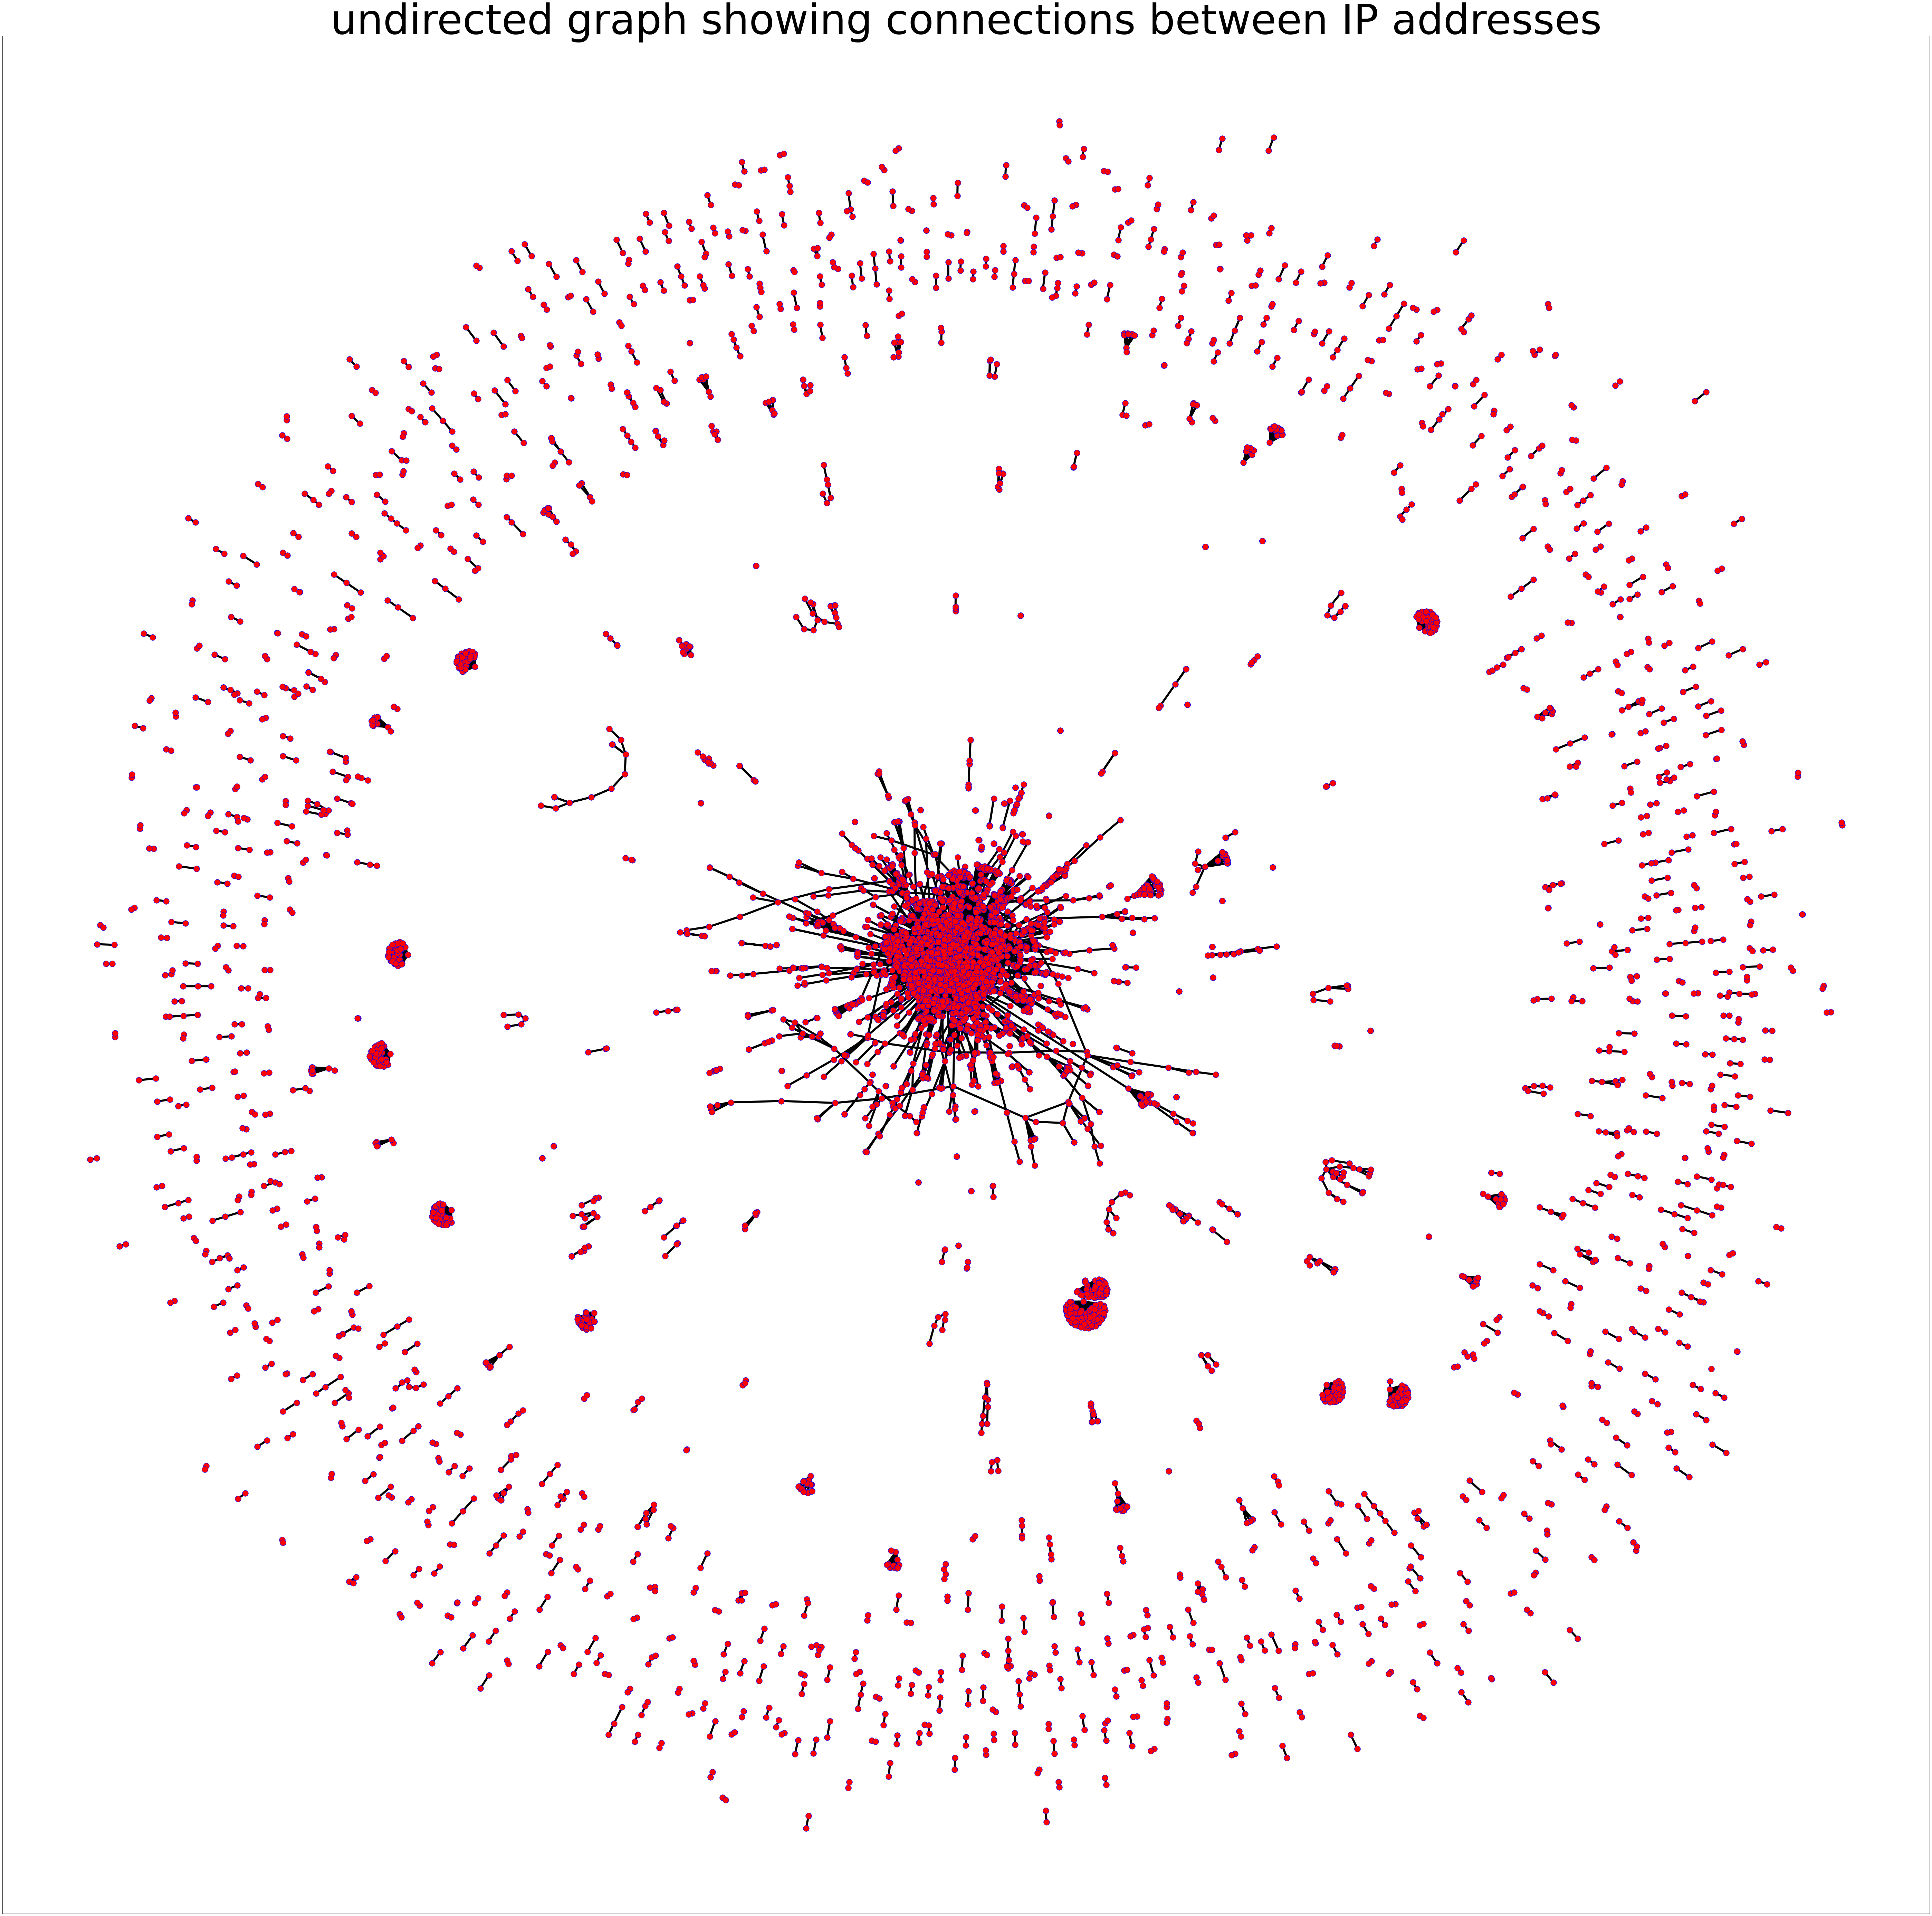

In [24]:
comm_dataset = IP_pair_communication_count_undirected.copy()
comm_dataset = pd.DataFrame(
    {"from": comm_dataset["IP_addr_1"], 
     "to" : comm_dataset["IP_addr_2"],
     "weight" : comm_dataset["correct_communication_count"]}
                           )

G = nx.from_pandas_edgelist(comm_dataset, "from", "to", edge_attr="weight")
communication_count = [i["weight"] for i in dict(G.edges).values()]

labels = [i for i in dict(G.nodes).keys()]
labels = {i:i for i in dict(G.nodes).keys()}

plt.figure(figsize=(100,100))
pos = nx.spring_layout(G, weight="weight")
nodes = nx.draw_networkx_nodes(G, pos, node_color='red', labels=True)
nodes.set_edgecolor('b')
edges = nx.draw_networkx_edges(G, pos, width=6)
# labels = nx.draw_networkx_labels(G, pos, labels, font_size=20)


plt.title("undirected graph showing connections between IP addresses", fontsize=120)
plt.show()

### Visualization of communications between different IP hosts
(After removing nodes which only communicate once)

In [25]:
comm_dataset = IP_pair_communication_count_undirected_more_than_one_communication.copy()
comm_dataset = pd.DataFrame(
    {"from": comm_dataset["IP_addr_1"], 
     "to" : comm_dataset["IP_addr_2"],
     "weight" : comm_dataset["correct_communication_count"]}
                           )

G = nx.from_pandas_edgelist(comm_dataset, "from", "to", edge_attr="weight")
communication_count = [i["weight"] for i in dict(G.edges).values()]

labels = [i for i in dict(G.nodes).keys()]
labels = {i:i for i in dict(G.nodes).keys()}

plt.figure(figsize=(100,100))
pos = nx.spring_layout(G, weight="weight")
nodes = nx.draw_networkx_nodes(G, pos, node_color='red', labels=True)
nodes.set_edgecolor('b')
edges = nx.draw_networkx_edges(G, pos, width=6)
# labels = nx.draw_networkx_labels(G, pos, labels, font_size=20)


plt.title("undirected graph showing connections between IP addresses", fontsize=120)
plt.show()

### Display top 10 IPs that communicate the most (Talker & Listener)

In [41]:
# For Talker
k_DF_talker = IP_pair_communication_count_directed.groupby("src_IP").agg({
    "number_of_times_communicated" : ["sum"]}).reset_index()
k_DF_talker.columns = ["src_IP", "times_communicated"]
k_DF_talker = k_DF_talker.sort_values("times_communicated", ascending=False)
# For Listener
k_DF_listener = IP_pair_communication_count_directed.groupby("dst_IP").agg({
    "number_of_times_communicated" : ["sum"]}).reset_index()
k_DF_listener.columns = ["dst_IP", "times_communicated"]
k_DF_listener = k_DF_listener.sort_values("times_communicated", ascending=False)

# Display top 10 most communicated
display_side_by_side([k_DF_talker.head(10), k_DF_listener.head(10)], ["k_DF_talker", "k_DF_listener"])

In [42]:
total_number_of_nodes_talker = len(k_DF_talker)
total_number_of_nodes_listener = len(k_DF_listener)

def find_pk_talker(k):
    temp_df = k_DF_talker[k_DF_talker["times_communicated"]==k]
    return len(temp_df)/total_number_of_nodes_talker

def find_pk_listener(k):
    temp_df = k_DF_listener[k_DF_listener["times_communicated"]==k]
    return len(temp_df)/total_number_of_nodes_listener

### Which Organisation to protect (Decision using Degree Distribution Graph)

In [43]:
pk_k_DF_talker = pd.DataFrame(sorted(k_DF_talker["times_communicated"].unique()))
pk_k_DF_talker.columns = ["k"]
pk_k_DF_talker["pk"] = pk_k_DF_talker["k"].apply(find_pk_talker)

pk_k_DF_listener = pd.DataFrame(sorted(k_DF_listener["times_communicated"].unique()))
pk_k_DF_listener.columns = ["k"]
pk_k_DF_listener["pk"] = pk_k_DF_listener["k"].apply(find_pk_listener)

display_side_by_side([pk_k_DF_talker.head(10), pk_k_DF_listener.head(10)], 
                     ["pk_k_DF_talker", "pk_k_DF_listener"])

### Degree Distribution Graph (Talker & Listener) Plotly Graph (Run code to see interactive graph)

In [44]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    name="Talker",
    x=pk_k_DF_talker["k"],
    y=pk_k_DF_talker["pk"],
    mode="lines",
    showlegend=True))

fig.add_trace(go.Scatter(
    name="Listener",
    x=pk_k_DF_listener["k"],
    y=pk_k_DF_listener["pk"],
    mode="lines",
    showlegend=True))

fig.update_layout(xaxis_type="log",
                  yaxis_type="log",
                  title={'text': "Degree Distribution Graph (Talker & Listener)",
                         'y':0.9,
                         'x':0.45,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  xaxis_title="Log k (number of unidirectional sent communication)",
                  yaxis_title="Log p(k) (Probability of an IP having k connections)",)
fig.show()

In [30]:
all_IP_addresses = set(list(IP_pair_communication_count_directed["src_IP"]) + 
                       list(IP_pair_communication_count_directed["dst_IP"]))
all_IP_addresses_DF = pd.DataFrame(all_IP_addresses)
all_IP_addresses_DF.columns = ["IP_address"]
all_IP_addresses_DF["Org"] = all_IP_addresses_DF["IP_address"].apply(find_org)
all_organisations = all_IP_addresses_DF["Org"].unique()
print(f"There are {len(all_organisations)} organisations in total.")

There are 848 organisations in total.


In [31]:
TALKER_CUTOFF = 249
LISTENER_CUTOFF = 249

talker_organisations_to_protect = IP_pair_communication_count_directed[IP_pair_communication_count_directed["number_of_times_communicated"]>TALKER_CUTOFF]
talker_organisations_to_protect = talker_organisations_to_protect[["src_IP", "number_of_times_communicated"]]
talker_organisations_to_protect["Org"] = talker_organisations_to_protect["src_IP"].apply(find_org)
print("Talker_organisations_to_protect:")
print(sorted(talker_organisations_to_protect["Org"].unique()))
number_of_talker_organisations_to_protect = len(talker_organisations_to_protect["Org"].unique())
print(f"\nNumber of talker organisations to protect reduced from {len(all_organisations)} to {number_of_talker_organisations_to_protect}")

Talker_organisations_to_protect:
['A*STAR', 'A-STAR', 'Asia Pacific Network Information Centre', 'Duke University', 'FDU', 'Facebook', 'Internet Archive', 'Internet2', 'JANET', 'JPNIC', 'Japan Advanced Institute of Science and Technology', 'Kyushu University', 'Microsoft Corporation', 'Multimedia Development Corporation', 'NOAA', 'Nanyang Technological University', 'National Climatic Data Center', 'National Infomation Society Agency', 'National Knowledge Network', 'National Library of Medicine', 'National Taiwan University', 'National University of Singapore', 'Republic Polytechnic, Singapore', 'Rutherford Appleton Laboratory', 'Singapore Telecommunications Ltd, Magix Services', 'THAINET', 'Taiwan Academic Network (TANet) Information Center', 'University of Chicago']

Number of talker organisations to protect reduced from 848 to 28


In [32]:
listener_organisations_to_protect = IP_pair_communication_count_directed[IP_pair_communication_count_directed["number_of_times_communicated"]>TALKER_CUTOFF]
listener_organisations_to_protect = listener_organisations_to_protect[["dst_IP", "number_of_times_communicated"]]
listener_organisations_to_protect["Org"] = listener_organisations_to_protect["dst_IP"].apply(find_org)
print("Listener_organisations_to_protect:")
print(sorted(listener_organisations_to_protect["Org"].unique()))
number_of_listener_organisations_to_protect = len(listener_organisations_to_protect["Org"].unique())
print(f"\nNumber of listener organisations to protect reduced from {len(all_organisations)} to {number_of_listener_organisations_to_protect}")

Listener_organisations_to_protect:
['A*STAR', 'A-STAR', 'Asia Pacific Network Information Centre', 'Duke University', 'ESnet', 'Google LLC', 'IITB', 'Institut Teknologi Bandung', 'International Islamic University Of Malaysia', 'Internet2', 'JANET', 'Microsoft Corporation', 'Multimedia Development Corporation', 'Nanyang Technological University', 'National Infomation Society Agency', 'National Knowledge Network', 'National University of Singapore', 'Republic Polytechnic, Singapore', 'SingAREN', 'Singapore Telecommunications Ltd, Magix Services', 'TANET']

Number of listener organisations to protect reduced from 848 to 21
